In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the libraries
import pyarrow
import numpy as np
import IPython, graphviz
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn import metrics
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [4]:
PATH = "C:/Users/vkonda/Desktop/DataS/"

### Loading the data:

In [5]:
df_raw = pd.read_csv(f'{PATH}takehome_data.csv', low_memory=False,
                    parse_dates=['created_at'])

In [6]:
df_raw.columns

Index(['funnel_search_id', 'created_at', 'tasker_id', 'position',
       'hourly_rate', 'num_completed_tasks', 'hired', 'category'],
      dtype='object')

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   funnel_search_id     30000 non-null  object        
 1   created_at           30000 non-null  datetime64[ns]
 2   tasker_id            30000 non-null  int64         
 3   position             30000 non-null  int64         
 4   hourly_rate          30000 non-null  int64         
 5   num_completed_tasks  30000 non-null  int64         
 6   hired                30000 non-null  int64         
 7   category             30000 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 1.8+ MB


In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 100):
        with pd.option_context("display.max_columns", 100):
            display(df)
            
display_all(df_raw.tail().transpose())

,29995,29996,29997,29998,29999
funnel_search_id,0-0-01899589-bb55-4423-80bf-cf4894256428,0-0-01899589-bb55-4423-80bf-cf4894256428,0-0-01899589-bb55-4423-80bf-cf4894256428,0-0-01899589-bb55-4423-80bf-cf4894256428,0-0-01899589-bb55-4423-80bf-cf4894256428
created_at,2017-09-30 23:15:00,2017-09-30 23:15:00,2017-09-30 23:15:00,2017-09-30 23:15:00,2017-09-30 23:15:00
tasker_id,1014157578,1009592218,1009194244,1007702812,1007341779
position,4,5,6,7,8
hourly_rate,200,155,175,150,200
num_completed_tasks,247,241,26,90,296
hired,0,0,0,1,0
category,Moving Help,Moving Help,Moving Help,Moving Help,Moving Help


 Looking at the dataset, Assumption is to predict what tasker is going to be hired when a customer fills out the initial requirement form at the website and then presented with available options.

In [9]:
#count of the Target variable
df_raw['hired'].value_counts()

0    28295
1     1705
Name: hired, dtype: int64

we can see imbalance in the dataset, so we need to do upsampling because of the difference of the classes before we train a predictive model.

### Data Analysis and feature selection

Based on the column descrpition, moving forward with the assumption that position, hourly rate and number of completed tasks are the levers that is impacting the hire/no hire decision.

Also few derived fields are added to the dataset to give more robustness to our model.

#### Hourly rate analysis

In [10]:
df_raw['hourly_rate'].describe()

count    30000.000000
mean        57.482533
std         36.222860
min         18.000000
25%         38.000000
50%         45.000000
75%         60.000000
max        290.000000
Name: hourly_rate, dtype: float64

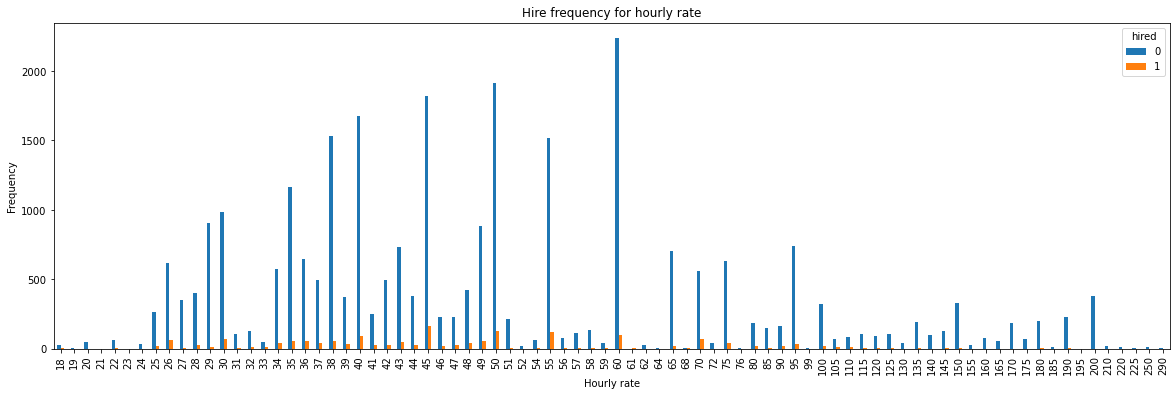

In [11]:
pd.crosstab(df_raw['hourly_rate'], df_raw['hired']).plot(kind="bar", figsize=(20,6))
plt.title('Hire frequency for hourly rate')
plt.xlabel('Hourly rate')
plt.ylabel('Frequency')
plt.show()

From the chart above, Hourly rate plays a role in deciding the hiring decision, we can see the lesser rates jobs shows higher hire rate than the higher rate jobs from the recommendations.

#### Position analysis

In [12]:
df_raw['position'].describe()

count    30000.000000
mean         7.873600
std          4.319442
min          1.000000
25%          4.000000
50%          8.000000
75%         12.000000
max         15.000000
Name: position, dtype: float64

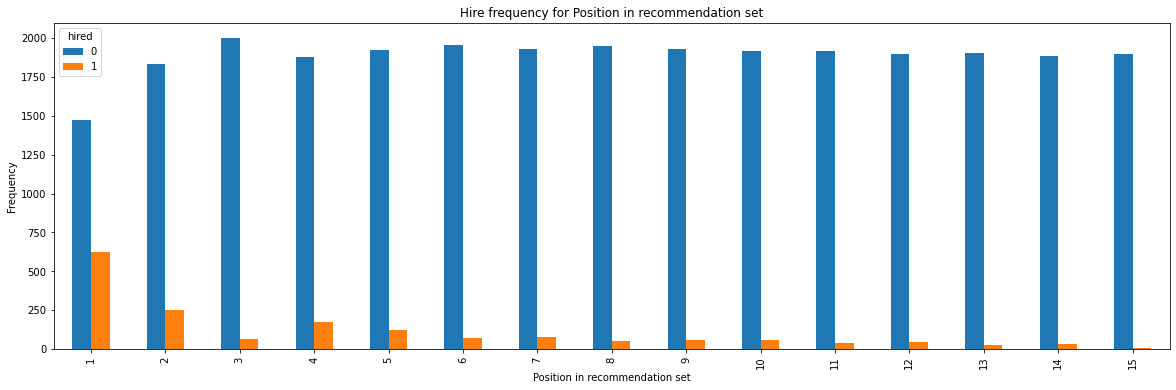

In [13]:
pd.crosstab(df_raw['position'], df_raw['hired']).plot(kind="bar", figsize=(20,6))
plt.title('Hire frequency for Position in recommendation set')
plt.xlabel('Position in recommendation set')
plt.ylabel('Frequency')
plt.show()

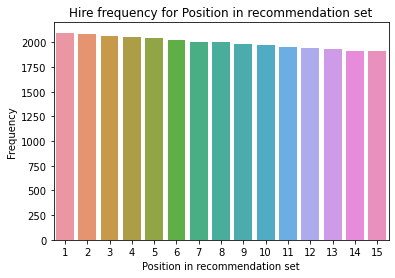

In [14]:
# total hires from being in specific position in the recommendation set
sns.barplot(df_raw['position'].value_counts().index,df_raw['position'].value_counts().values )
plt.title('Hire frequency for Position in recommendation set')
plt.xlabel('Position in recommendation set')
plt.ylabel('Frequency')
plt.show()

Placement of the tasker in the recommendation set could be the possible lever in the hiring decision, we can see majority of the hires are from the positions less than 6

#### Correlation analysis

This step converts the created at date field and derives various measures from it. we are seeing if day of the week, day of the year is playing any major role in hiring decision 

In [15]:
# passing dataframe and passing field, getattr finds looks for all fields associated with these fields

def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'hour', 'Dayofweek', 'Dayofyear',
             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
             'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt, n.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace=True)

In [16]:
add_datepart(df_raw, 'created_at')

In [17]:
df_raw.columns

Index(['funnel_search_id', 'tasker_id', 'position', 'hourly_rate',
       'num_completed_tasks', 'hired', 'category', 'created_atYear',
       'created_atMonth', 'created_atWeek', 'created_atDay', 'created_athour',
       'created_atDayofweek', 'created_atDayofyear', 'created_atIs_month_end',
       'created_atIs_month_start', 'created_atIs_quarter_end',
       'created_atIs_quarter_start', 'created_atIs_year_end',
       'created_atIs_year_start', 'created_atElapsed'],
      dtype='object')

In [18]:
df_raw.corr()

,tasker_id,position,hourly_rate,num_completed_tasks,hired,created_atYear,created_atMonth,created_atWeek,created_atDay,created_athour,created_atDayofweek,created_atDayofyear,created_atIs_month_end,created_atIs_month_start,created_atIs_quarter_end,created_atIs_quarter_start,created_atIs_year_end,created_atIs_year_start,created_atElapsed
tasker_id,1.000000,-0.039069,-0.086698,-0.313843,0.008412,NaN,NaN,0.031548,0.031486,-0.001036,-0.005160,0.031486,0.016718,0.008851,0.016718,NaN,NaN,NaN,0.031717
position,-0.039069,1.000000,0.140029,0.024309,-0.213608,NaN,NaN,0.003548,0.002855,-0.004467,-0.003734,0.002855,-0.005654,-0.004327,-0.005654,NaN,NaN,NaN,0.002870
hourly_rate,-0.086698,0.140029,1.000000,0.287258,-0.046519,NaN,NaN,0.068817,0.069686,-0.047935,-0.006643,0.069686,0.001766,0.019292,0.001766,NaN,NaN,NaN,0.069426
num_completed_tasks,-0.313843,0.024309,0.287258,1.000000,0.041825,NaN,NaN,0.005321,-0.001026,-0.013893,-0.029975,-0.001026,-0.032959,-0.012417,-0.032959,NaN,NaN,NaN,-0.001295
hired,0.008412,-0.213608,-0.046519,0.041825,1.000000,NaN,NaN,0.001493,0.001234,0.002683,-0.001419,0.001234,0.007841,-0.003075,0.007841,NaN,NaN,NaN,0.001275
created_atYear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_atMonth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
created_atWeek,0.031548,0.003548,0.068817,0.005321,0.001493,NaN,NaN,1.000000,0.977620,-0.046401,-0.257320,0.977620,0.207024,-0.326146,0.207024,NaN,NaN,NaN,0.977630
created_atDay,0.031486,0.002855,0.069686,-0.001026,0.001234,NaN,NaN,0.977620,1.000000,-0.053141,-0.048266,1.000000,0.254089,-0.313666,0.254089,NaN,NaN,NaN,0.999820
created_athour,-0.001036,-0.004467,-0.047935,-0.013893,0.002683,NaN,NaN,-0.046401,-0.053141,1.000000,-0.023788,-0.053141,-0.015012,0.005015,-0.015012,NaN,NaN,NaN,-0.046604


we can clearly see that position and number of completed tasks are making major impact on the hiring decision which proves our initial assumption:
1. position is negatively correlated - lower in the list of the recommendation set is a possibility that earlier records may get hired before reaching to that particular record
2. number of completed tasks - It defines the success in this criteria and building trust. more the number of completed tasks more chance of getting hired on the task. 
3. we can also observe hourly rate is negatively correlated to hiring decision as well.

Now we have observed the correlation factors of the fields, we can now build more features to get more accurate predictions 

### Preprocessing the data for Modeling

In [19]:
def train_cats(df):
    """change any columns of strings in the dataframe to a column of categorical values. 
    This applies the changes inplace"""
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def apply_cats(df, trn):
    """Changes any columns of strings in the dataframe into categorical variables 
    using trn as a template for the category codes"""
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """Fill missing data in a column of the dataframe with the median,
    and add a {name}_na column which specifies if the data was missing"""
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """Changes the column col from a categorical type to its integer codes"""
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1

def scale_vars(df, mapper):
    """standard scaling"""
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """proc_df takes a dataframe df and process the response variable, and changes the df into an entirely numeric dataframe"""
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [20]:
train_cats(df_raw)

In [21]:
df_raw.funnel_search_id.cat.categories

Index(['0-0-00033225-3f89-47dd-b4f1-5d1feb359a76',
       '0-0-000ea7f0-2ad9-48ee-bc79-899ee439be82',
       '0-0-0027ac52-1983-4130-8a65-5048dda560c9',
       '0-0-003a3672-3c80-4134-b409-b80baee0e082',
       '0-0-0045d200-f7c0-4fe6-94df-b89a4cde3ee7',
       '0-0-0046a0f0-1d70-42e4-a6d3-43e9a4c614d9',
       '0-0-004cc112-d2ee-4753-8e55-76e95369364e',
       '0-0-00549753-28f1-4291-b176-e1bec0d77b0e',
       '0-0-006326c7-5448-48fe-8e08-55d0fdfb9fe2',
       '0-0-006fe8d8-309a-4f2f-ae14-2936321fc19d',
       ...
       '0-1078833-2fcc37f5-1beb-4cbb-99b9-c68ff2f58a1d',
       '0-1078833-389b5181-77d2-4393-87b4-254ddfcb4e1a',
       '0-1078833-3a488665-f9d0-489f-b46a-2e8e26c1fc85',
       '0-1078833-47012ad9-ca2e-4644-9196-dc90be99b4c0',
       '0-1078833-52edd4ef-15a7-4899-a60a-2518a8db8646',
       '0-1078833-533e288a-39c8-4721-8c5b-5b9fe472d478',
       '0-1078833-54d459fd-bb51-40fd-88bf-62ab8dfc8d77',
       '0-1078833-569d76c9-681f-4ed6-92e6-0a0942a3ac76',
       '0-1078833-59332

In [22]:
df_raw.category.cat.categories

Index(['Furniture Assembly', 'Mounting', 'Moving Help'], dtype='object')

In [23]:
# checking for nulls in the dataset
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

category                      0.0
created_atDay                 0.0
created_atDayofweek           0.0
created_atDayofyear           0.0
created_atElapsed             0.0
created_atIs_month_end        0.0
created_atIs_month_start      0.0
created_atIs_quarter_end      0.0
created_atIs_quarter_start    0.0
created_atIs_year_end         0.0
created_atIs_year_start       0.0
created_atMonth               0.0
created_atWeek                0.0
created_atYear                0.0
created_athour                0.0
funnel_search_id              0.0
hired                         0.0
hourly_rate                   0.0
num_completed_tasks           0.0
position                      0.0
tasker_id                     0.0
dtype: float64

In [24]:
# saving the file on ram
import os
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

In [25]:
df_raw = pd.read_feather('tmp/raw')
df_raw['hired'].value_counts()

0    28295
1     1705
Name: hired, dtype: int64

Since the dataset has imbalanced classes, SMOTE method is best in this scenario to upsample the lower class to match the upper class

In [26]:
X, y, nas = proc_df(df_raw, 'hired')

In [27]:
# SMOTE based algorithm to upsample - duplicates randomly selected data observations from the outnumbered class
seed = 1000
sm = SMOTE(sampling_strategy = 'auto', random_state=seed)
X_res, y_res = sm.fit_resample(X, y)

In [28]:
print(X[y==0].shape)
print(X[y==1].shape)
print(X_res[y_res==0].shape)
print(X_res[y_res==1].shape)

(28295, 20)
(1705, 20)
(28295, 20)
(28295, 20)


In [29]:
df_smoted = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis = 1)
df_smoted.columns = ['funnel_search_id', 'tasker_id', 'position', 'hourly_rate', 'num_completed_tasks', 'category', 
              'created_atYear', 'created_atMonth', 'created_atWeek', 'created_atDay','created_athour', 'created_atDayofweek',
              'created_atDayofyear', 'created_atIs_month_end', 'created_atIs_month_start', 'created_atIs_quarter_end',
              'created_atIs_quarter_start', 'created_atIs_year_end', 'created_atIs_year_start',
              'created_atElapsed', 'hired'
             ]

In [30]:
df_smoted['hired'].value_counts()

0    28295
1    28295
Name: hired, dtype: int64

The classes are now balanced

In [31]:
# seperating the target variable from the dataset, 
# also one hot encoding the categorical features which as less than 7 levels. Idea is to preserve field funnel_search_id
df_trn, y_trn, nas = proc_df(df_smoted, 'hired', max_n_cat=7)

In [32]:
# splitting the dataset into train and validation sets
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

#### Feature Importance

As a baseline, model is trained using Random Forest as
1. It takes less training time as compared to other algorithms
2. It predicts output with high accuracy in classification models, even for the large datasets it runs efficiently
3. Assuming the predictions from each tree has very low correlation
4. Assuming there are some actual values in the feature vaiable of the dataset so theat the classifier can predict accurate results than a guessed result.

In [33]:
#establishing a baseline model
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: total: 2.08 s
Wall time: 348 ms


RandomForestClassifier(n_estimators=40, n_jobs=-1)

In [34]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

In [35]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [36]:
fi = rf_feat_importance(m, df_trn);
fi[:15]

,cols,imp
2,position,0.249144
4,num_completed_tasks,0.131543
1,tasker_id,0.107411
3,hourly_rate,0.090298
10,created_athour,0.082399
0,funnel_search_id,0.078666
11,created_atDayofweek,0.053217
9,created_atDay,0.047126
12,created_atDayofyear,0.046538
8,created_atWeek,0.044817


<AxesSubplot:xlabel='cols'>

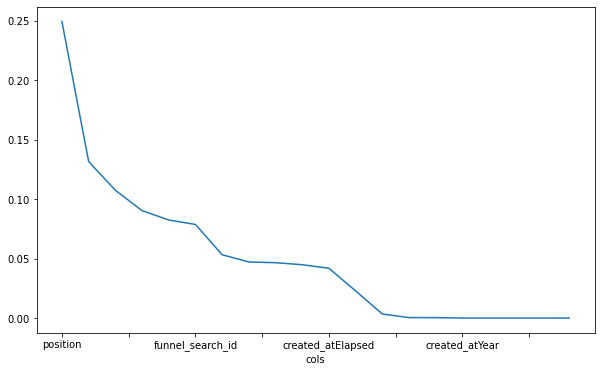

In [37]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False)

In [38]:
def plot_fi(fi):
    return fi.plot('cols', 'imp','barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

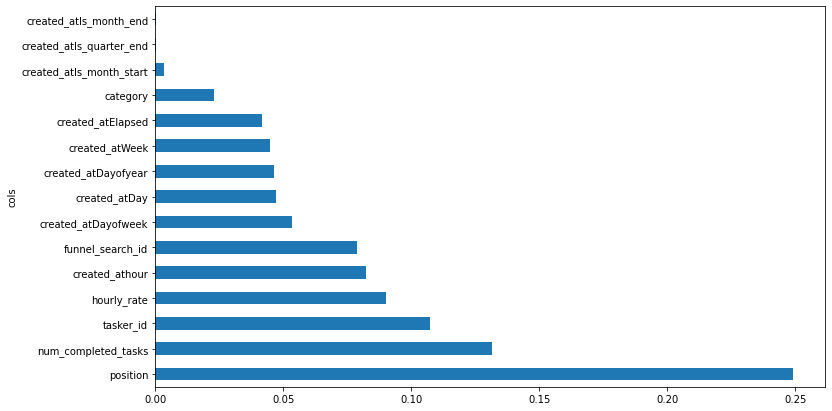

In [39]:
plot_fi(fi[:15])

In [40]:
to_keep = fi[fi.imp>0.03].cols; len(to_keep)

11

In [41]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [42]:
m = RandomForestClassifier(n_estimators=40, n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: total: 2.27 s
Wall time: 327 ms


RandomForestClassifier(n_estimators=40, n_jobs=-1)

<AxesSubplot:ylabel='cols'>

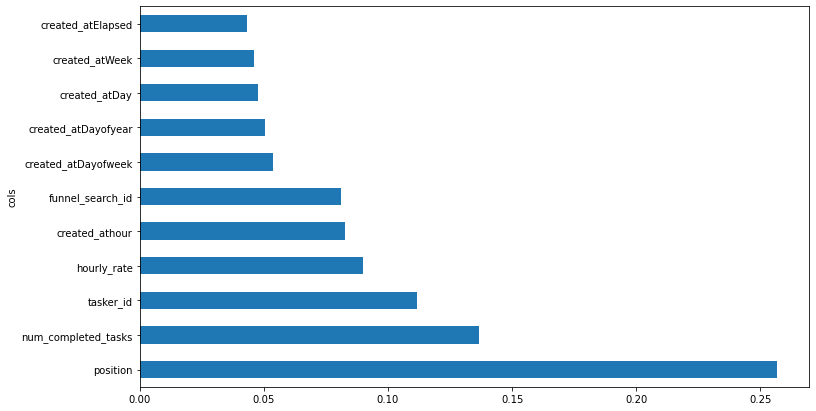

In [43]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

#### Checking for collinearity

In [44]:
import scipy
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy as hc

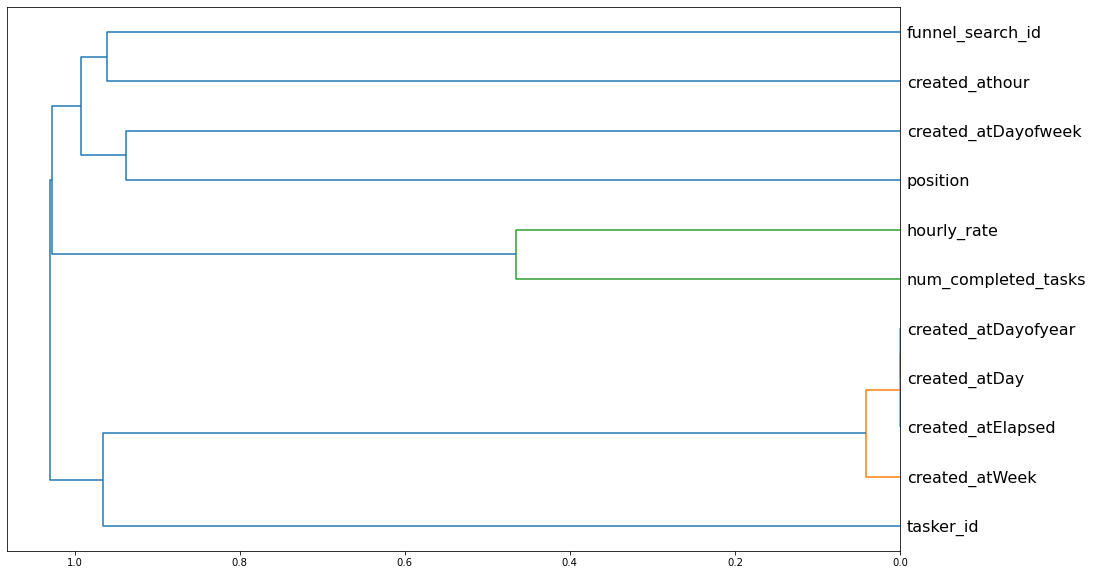

In [45]:
corr= np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [46]:
def get_oob(df):
    m=RandomForestClassifier(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [47]:
get_oob(df_keep)

0.9326979143305674

In [48]:
 for c in ('created_atDay', 'created_atElapsed', 'created_atDayofyear'):
        print(c, get_oob(df_keep.drop(c, axis=1)))

created_atDay 0.9313074680421619
created_atElapsed 0.9321372505045974
created_atDayofyear 0.9313747477012783


In [49]:
to_drop = ['created_atElapsed']
get_oob(df_keep.drop(to_drop, axis=1))

0.9318232787620543

In [50]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [51]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False ,n_jobs=-1)
%time m.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 19.6 ms


RandomForestClassifier(bootstrap=False, max_depth=3, n_estimators=1, n_jobs=-1)

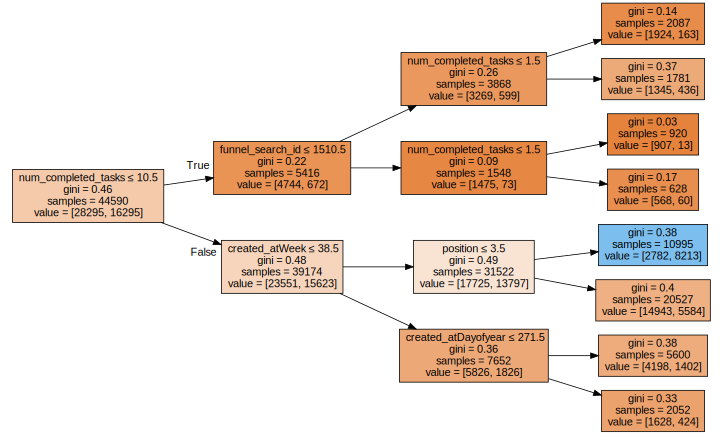

In [52]:
# lowest splits to largest splits, we tried every variable and every possible split 
# and find variable with max mse 
draw_tree(m.estimators_[0], X_train, precision=2)

#### Model selection

In [53]:
# Intialization of classifier 
classifiers =[]
model1 = LogisticRegression()
classifiers.append(model1)
model2 = SVC()
classifiers.append(model2)
model3 = DecisionTreeClassifier()
classifiers.append(model3)
model4 = RandomForestClassifier()
classifiers.append(model4)
model5 = AdaBoostClassifier()
classifiers.append(model5)

In [54]:
# List of models 
model_name = ['LogisticRegression','Support Vector Machine','DecisionTreeClassifier','RandomForestClassifier','AdaBoostClassifier']
Training_score ,Testing_score,TP,FP,FN,Precision,Recall,classifiers_list = [],[],[],[],[],[],[],[]

For measuring the performance of the models, choosing Precision and recall.

In [55]:
# Running for differnent classifier and Save scores for different classfiers into model
for i in range(0,len(classifiers)):
    clf = classifiers[i]
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_valid)
    cm = confusion_matrix(y_valid, y_pred)
    classifiers_list.append(model_name[i])
    Training_score.append(clf.score(X_train,y_train))
    Testing_score.append(clf.score(X_valid,y_valid))
    TP.append(cm[1][1])
    FP.append(cm[0][1])
    FN.append(cm[1][0])
    Precision.append( precision_score(y_valid,y_pred))
    Recall.append(recall_score(y_valid,y_pred))
       
Score_DF = pd.DataFrame()
Score_DF['classifiers'] = classifiers_list
Score_DF['Training_score'] = Training_score
Score_DF['Testing_score'] = Testing_score
Score_DF['True_positive'] = TP
Score_DF['False_positive'] = FP
Score_DF['False_negative'] = FN
Score_DF['Precision'] = Precision
Score_DF['Recall'] = Recall
%time

CPU times: total: 0 ns
Wall time: 0 ns


In [56]:
Score_DF

,classifiers,Training_score,Testing_score,True_positive,False_positive,False_negative,Precision,Recall
0,LogisticRegression,0.634559,0.000000,0,0,12000,0.0,0.000000
1,Support Vector Machine,0.634559,0.000000,0,0,12000,0.0,0.000000
2,DecisionTreeClassifier,0.999978,0.931917,11183,0,817,1.0,0.931917
3,RandomForestClassifier,0.999978,0.967500,11610,0,390,1.0,0.967500
4,AdaBoostClassifier,0.814689,0.708000,8496,0,3504,1.0,0.708000


From above matrix we can see RandomForestClassifier works best for this scenario that proves our assumptions, we can get better results adding more data, features and tuning the hyperparameters.

#### From Analysing the features from the spreadsheet, we can see below observations:
1. Target variable - Hired is dependent on features in the order of position in the recommendation set, number of completed tasks, hourly rate, hour of the day, day of the week etc. 
2. Decision of Hire is more observed in these criteria: 
   a. tasker has more number of tasks completed prior to recommendation
   b. tasker has a lower hourly rate
   c. tasker's position in recommendation set is as early as possible
   
#### In order to successfully predict if the tasker is going to be hired:
keep adding more features into the model to get better performance, for example:
1. what is the rating the tasker got after the finished the job and average rating
2. how is the user experience with the tasker
3. how many times tasker have been added to job and cancelled.
4. what is the tenure of the tasker